<a href="https://www.kaggle.com/code/yujansaya/house-price-prediction?scriptVersionId=161184237" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Feature selection and data formating


## Importing libraries and datasets

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # for data visualisation

# data preprocessing packages
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
import statsmodels.api as sm

#packages to evaluate and tune our models
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import GridSearchCV

# packages for model implementation
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

import os
for dirname, _, filenames in os.walk('/kaggle/input'):

    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
train_set_path = '../input/house-prices-advanced-regression-techniques/train.csv'
test_set_path = '../input/house-prices-advanced-regression-techniques/test.csv'

df_train = pd.read_csv(train_set_path)
df_test = pd.read_csv(test_set_path)

In [3]:
y = df_train['SalePrice'].values
df_train.drop('SalePrice', axis = 1, inplace=True)

## Combining train and test sets in order to perform manual feature selection, deal with missing values and format the data types.

**We will split it back to the original for feature scaling and model training and prediction.**

In [4]:
df_all = pd.concat([df_train, df_test]).reset_index(drop=True)

In [5]:
# df_all which numerical on data but should be treated as category.
df_all['MSSubClass'] = df_all['MSSubClass'].astype(str)
df_all['YrSold'] = df_all['YrSold'].astype(str)
df_all['MoSold'] = df_all['MoSold'].astype(str)

In [6]:
print({col: df_all[col].isnull().sum() for col in df_all.columns.tolist() if df_all[col].isnull().sum() != 0})

{'MSZoning': 4, 'LotFrontage': 486, 'Alley': 2721, 'Utilities': 2, 'Exterior1st': 1, 'Exterior2nd': 1, 'MasVnrType': 1766, 'MasVnrArea': 23, 'BsmtQual': 81, 'BsmtCond': 82, 'BsmtExposure': 82, 'BsmtFinType1': 79, 'BsmtFinSF1': 1, 'BsmtFinType2': 80, 'BsmtFinSF2': 1, 'BsmtUnfSF': 1, 'TotalBsmtSF': 1, 'Electrical': 1, 'BsmtFullBath': 2, 'BsmtHalfBath': 2, 'KitchenQual': 1, 'Functional': 2, 'FireplaceQu': 1420, 'GarageType': 157, 'GarageYrBlt': 159, 'GarageFinish': 159, 'GarageCars': 1, 'GarageArea': 1, 'GarageQual': 159, 'GarageCond': 159, 'PoolQC': 2909, 'Fence': 2348, 'MiscFeature': 2814, 'SaleType': 1}


In [7]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   object 
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

## Dealing with missing values

In [8]:
# List of columns where NaN value means absence of the feature (which is a real class and we need to keep them)
none = [
    'Alley', 'PoolQC', 'MiscFeature', 'Fence', 'FireplaceQu', 'GarageType',
    'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond',
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType'
]

# List of columns where NaN values mean 0

zero= [
    'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
    'BsmtHalfBath', 'GarageYrBlt', 'GarageArea', 'GarageCars', 'MasVnrArea'
]

# List of columns where NaN values are catually missing values and we need to deal with them

real_nans = [
    'Electrical', 'Exterior1st', 'Exterior2nd', 'Functional', 'KitchenQual',
    'SaleType', 'Utilities'
]

# Filling the columns above with respective values

for col in zero:
    df_all[col].replace(np.nan, 0, inplace=True)

for col in none:
    df_all[col].replace(np.nan, 'None', inplace=True)

for col in real_nans:
    df_all[col].replace(np.nan, df_all[col].mode()[0], inplace=True)

# Filling MSZoning according to MSSubClass 
temp = df_all.groupby('MSSubClass')['MSZoning'].apply(lambda x: x.fillna(x.mode()[0]))
df_all['MSZoning'] = temp.droplevel(0) 

# Filling LotFrontage according to Neighborhood
temp = df_all.groupby(['Neighborhood'])['LotFrontage'].apply(lambda x: x.fillna(x.median()))
df_all['LotFrontage'] = temp.droplevel(0) 

## Label and Ordinal Encoding of categorical features

I have tried to encode using LabelEncoder those columns that are not ordinal. But the best resuts were achieved using One Hot encoding (find below). <br><br>
Keeping the commented out code for Label Encoding just in case anyone interested.

In [9]:
df_all['BsmtFinType1'].unique()

array(['GLQ', 'ALQ', 'Unf', 'Rec', 'BLQ', 'None', 'LwQ'], dtype=object)

In [10]:
# from sklearn.preprocessing import LabelEncoder

# le = LabelEncoder()
# for col in ['Neighborhood', 'MSSubClass', 'MSZoning', 'Condition1', 'Condition2', 'HouseStyle',
#             'Exterior1st', 'Exterior2nd', 'MiscFeature', 'SaleType']:
#   df_all[col] = LabelEncoder().fit_transform(df_all[col])

In [11]:
oe = OrdinalEncoder(categories=[['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex']])
columns = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageCond', 'GarageQual', 'PoolQC']
for col in columns:
  df_all[col] = oe.fit_transform(df_all[col].values.reshape(-1, 1))

In [12]:
oe1 = OrdinalEncoder(categories=[['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']])
columns = ['BsmtFinType1', 'BsmtFinType2']
for col in columns:
  df_all[col] = oe1.fit_transform(df_all[col].values.reshape(-1, 1))

## New Feature Engineering and Droping the corresponding ones

In [13]:
# Creating new features  based on previous observations

df_all['TotalSF'] = (df_all['BsmtFinSF1'] + df_all['BsmtFinSF2'] +
                       df_all['1stFlrSF'] + df_all['2ndFlrSF'])

df_all['TotalBathrooms'] = (df_all['FullBath'] +
                              (0.5 * df_all['HalfBath']) +
                              df_all['BsmtFullBath'] +
                              (0.5 * df_all['BsmtHalfBath']))

df_all['TotalPorchSF'] = (df_all['OpenPorchSF'] + df_all['3SsnPorch'] +
                            df_all['EnclosedPorch'] +
                            df_all['ScreenPorch'] + df_all['WoodDeckSF'])

df_all['YearBlRm'] = (df_all['YearBuilt'] + df_all['YearRemodAdd'])

# Merging quality and conditions

df_all['TotalExtQual'] = (df_all['ExterQual'] + df_all['ExterCond'])
df_all['TotalBsmQual'] = (df_all['BsmtQual'] + df_all['BsmtCond'] +
                            df_all['BsmtFinType1'] +
                            df_all['BsmtFinType2'])
df_all['TotalGrgQual'] = (df_all['GarageQual'] + df_all['GarageCond'])

df_all.drop(['BsmtFinSF1', 'BsmtFinSF2', '1stFlrSF', '2ndFlrSF', 'FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath',
             'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd',
             'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'GarageQual', 'GarageCond'], axis=1, inplace=True)

In [14]:
df_all.shape

(2919, 64)

## Converting the rest of categorical features with One Hot encoding.

In [15]:
df_all_dummies = pd.get_dummies(data=df_all)

In [16]:
df_all_dummies.info()
df_all_dummies.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Columns: 265 entries, Id to SaleCondition_Partial
dtypes: bool(235), float64(16), int64(14)
memory usage: 1.3 MB


(2919, 265)

In [17]:
X = df_all_dummies.iloc[:len(y), 1:].values   # splitting back to train and test sets without ID column
X_test = df_all_dummies.iloc[len(X):, 1:].values

# Feature Scaling

In [18]:
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size = 0.1, random_state = 0)

In [19]:
sc = StandardScaler()

X_ = sc.fit_transform(X)
X_train = sc.fit_transform(X_train)
X_dev = sc.transform(X_dev)
X_test = sc.transform(X_test)

# Lasso regression

Feature selection using Lasso regularization

In [20]:
reg = LassoCV()
reg.fit(X_, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X_,y))
coef = pd.Series(reg.coef_, index = df_all_dummies.columns[1:])

Best alpha using built-in LassoCV: 1262.120500
Best score using built-in LassoCV: 0.897731


In [21]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 65 variables and eliminated the other 199 variables


In [22]:
cols_laso = coef.sort_values().tail(65).index
cols_laso

Index(['Utilities_NoSeWa', 'LotConfig_Corner', 'MoSold_8', 'LotConfig_FR2',
       'LotConfig_FR3', 'LotConfig_Inside', 'LandSlope_Gtl', 'LandSlope_Mod',
       'LandSlope_Sev', 'Neighborhood_Blmngtn', 'Neighborhood_Blueste',
       'Fence_None', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr',
       'MoSold_6', 'Neighborhood_Edwards', 'Neighborhood_Gilbert',
       'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_BrDale',
       'BsmtExposure_None', 'MoSold_7', 'MSSubClass_20', 'SaleType_Con',
       'MasVnrType_Stone', 'TotalBathrooms', 'MoSold_1', 'Exterior2nd_ImStucc',
       'LotFrontage', 'LotShape_IR2', 'LandContour_HLS', 'HeatingQC',
       'Foundation_PConc', 'TotalPorchSF', 'Neighborhood_BrkSide',
       'Exterior1st_CemntBd', 'RoofStyle_Hip', 'Neighborhood_Somerst',
       'LotConfig_CulDSac', 'Exterior1st_BrkFace', 'Fireplaces', 'PoolQC',
       'Condition1_Norm', 'GarageFinish_Fin', 'OverallCond', 'TotalExtQual',
       'Functional_Typ', 'GarageCars', 'Neighbor

In [23]:
indexes = [df_all_dummies.columns.get_loc(col) - 1 for col in cols_laso]

In [24]:
X_ = X_[:, indexes]
X_train = X_train[:, indexes]
X_dev = X_dev[:, indexes]
X_test = X_test[:, indexes]

Text(0.5, 1.0, 'Feature importance using Lasso Model')

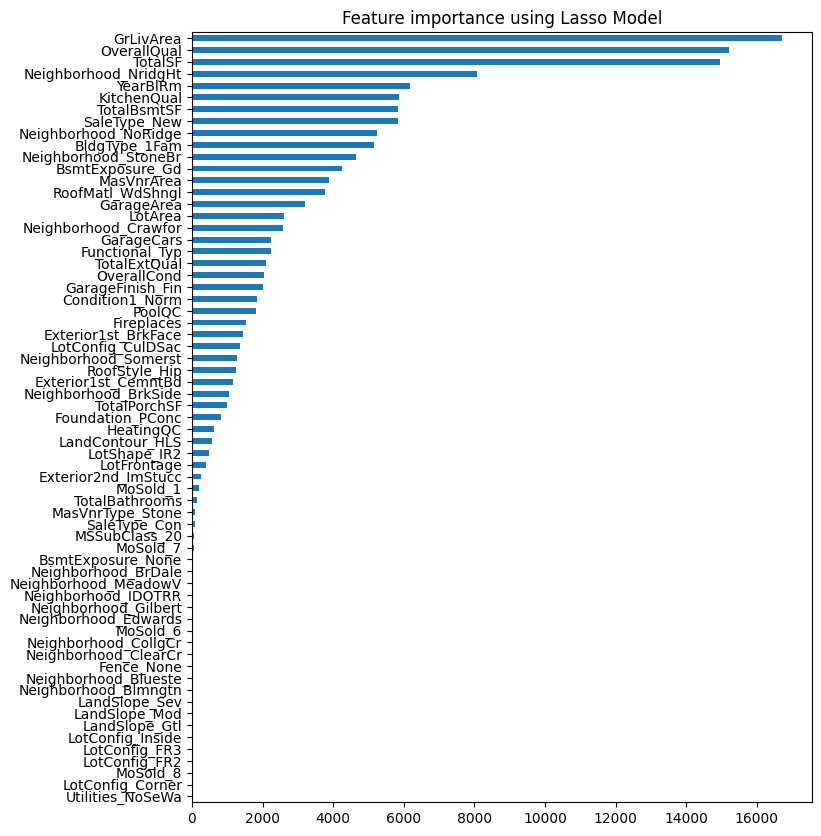

In [25]:
imp_coef = coef.sort_values().tail(65)
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

# Backward Elimination of features

I have tried to use Lasso and Backward Elimination separately and combined. The best results were achieved with Lasso only. <br><br>
Keeping the commented out code just in case.

In [26]:
# X_1 = sm.add_constant(X_)
# #Fitting sm.OLS model
# model = sm.OLS(y,X_1).fit()
# pvalues = model.pvalues
# indexes = [i-1 for i in range(1, len(pvalues)) if pvalues[i] > 0.05]

# X_ = np.delete(X_, indexes, axis = 1)
# X_test = np.delete(X_test, indexes, axis = 1)
# cols_be = np.delete(cols_laso, indexes)

# Training and testing models

## Linear Regression

In [27]:
regressor = SGDRegressor()
regressor.fit(X_train, y_train)

SGDRegressor()

In [28]:
y_pred = regressor.predict(X_dev)
np.sqrt(mean_squared_log_error(y_dev, y_pred))

0.16311159726122865

**Hyperparameters tuning**

In [29]:
parameters = [{
    #'loss': [ 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    #'penalty': ['l2', 'l1', 'elasticnet']
    #'alpha':[0, 0.001, 0.005, 0.01, 0.05, 0.0001]
    #'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive']
    #'eta0': [0.001, 0.005, 0.01, 0.05, 0.0001]
    #'epsilon': [0, 0.001, 0.005, 0.01, 0.05, 0.0001]
              },
              ]
grid_search = GridSearchCV(estimator = regressor,
                           param_grid = parameters,
                           scoring = 'neg_mean_squared_log_error',
                           cv = 10,
                           n_jobs = -1)
grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best Accuracy: -3.86 %
Best Parameters: {}


## Random Forest

In [30]:
regressor = RandomForestRegressor(n_estimators = 80, random_state = 0, max_depth = 80, min_samples_split = 5
                                 )
regressor.fit(X_train, y_train)

RandomForestRegressor(max_depth=80, min_samples_split=5, n_estimators=80,
                      random_state=0)

In [31]:
y_pred = regressor.predict(X_dev)

In [32]:
np.sqrt(mean_squared_log_error(y_dev, y_pred))

0.13020122628966296

**Hyperparameters tuning**

In [33]:
parameters = {
    #'bootstrap': [True],
    #'max_depth': [80, 90, 100, 110],
    # 'max_features': [2, 3],
    # 'min_samples_leaf': [3, 4, 5],
    #'min_samples_split': [3, 4, 5],
    #'n_estimators': [100, 200, 300, 1000]
}

grid_search = GridSearchCV(estimator = regressor,
                           param_grid = parameters,
                           scoring = 'neg_mean_squared_log_error',
                           cv = 10,
                           n_jobs = -1)
grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best Accuracy: -2.01 %
Best Parameters: {}


## Decision Tree

In [34]:
regressor = DecisionTreeRegressor()
regressor.fit(X_train, y_train)

DecisionTreeRegressor()

In [35]:
y_pred = regressor.predict(X_dev)

In [36]:
np.sqrt(mean_squared_log_error(y_dev, y_pred))

0.20774206484008664

<Axes: >

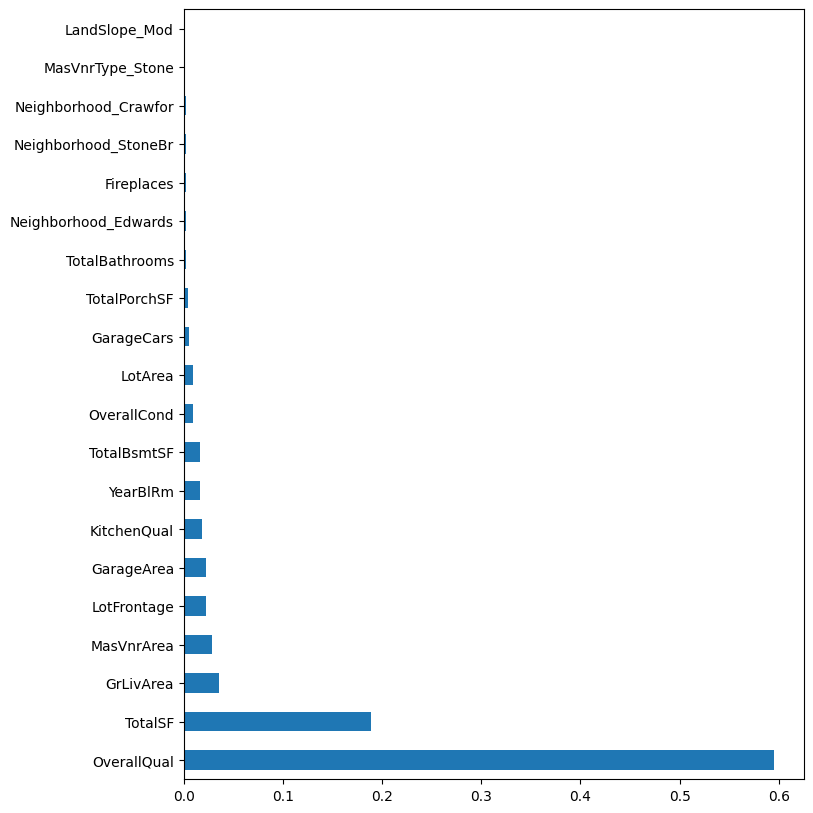

In [37]:
feat_importances = pd.Series(regressor.feature_importances_, index=cols_laso)
feat_importances.nlargest(20).plot(kind='barh')

## XGBoost

In [38]:
regressor = XGBRegressor()
regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [39]:
y_pred = regressor.predict(X_dev)
np.sqrt(mean_squared_log_error(y_dev, y_pred))

0.1237578830333839

<Axes: >

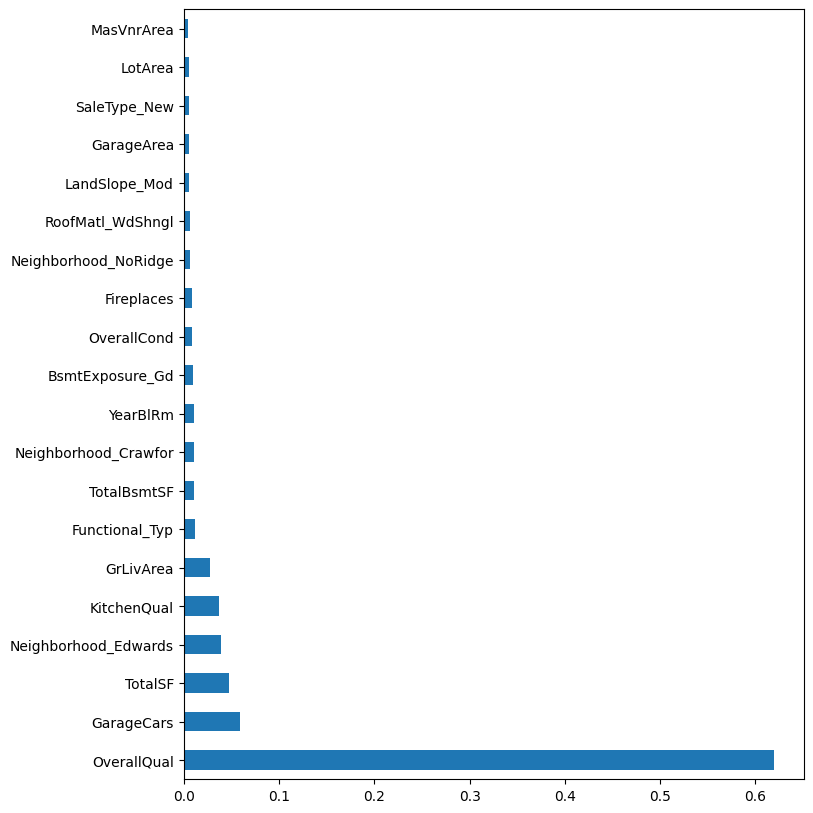

In [40]:
feat_importances = pd.Series(regressor.feature_importances_, index=cols_laso)
feat_importances.nlargest(20).plot(kind='barh')

**Hyperparameters tuning**

In [41]:
parameters = [{
    #'tree_method': [ 'exact', 'approx', 'hist']
    #'sampling_method': ['uniform', 'gradient_based']
    #'subsample': [0, 0.001, 0.005, 0.01, 0.05]
    #'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
#     'subsample':[i/10.0 for i in range(6,10)],
#  'colsample_bytree':[i/10.0 for i in range(6,10)]
    #'min_child_weight': [1, 5, 10],
        #'gamma': [0.5, 1, 1.5, 2, 5],
        #'subsample': [0.6, 0.8, 1.0],
        #'colsample_bytree': [0.6, 0.8, 1.0],
    #'eta': [0.1, 0.3, 0.01, 0.001],
               #'max_depth': [3, 6, 10, 30, 50],
    #"booster": ['gbtree', 'gblinear', 'dart']
    #'lambda': [0.001, 0.1, 0.5, 0.9]
              },
              ]
grid_search = GridSearchCV(estimator = regressor,
                           param_grid = parameters,
                           scoring = 'neg_mean_squared_log_error',
                           cv = 10,
                           n_jobs = -1)
grid_search.fit(X_, y)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best Accuracy: -1.83 %
Best Parameters: {}


## Gradient Boosting

In [42]:
regressor = GradientBoostingRegressor(learning_rate=0.001, min_samples_split=200,min_samples_leaf=30,max_depth=9,max_features=19,subsample=0.9,random_state=10,
                                      n_estimators = 8000, )
regressor.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.001, max_depth=9, max_features=19,
                          min_samples_leaf=30, min_samples_split=200,
                          n_estimators=8000, random_state=10, subsample=0.9)

In [43]:
y_pred = regressor.predict(X_dev)
np.sqrt(mean_squared_log_error(y_dev, y_pred))

0.12724583069865927

**Hyperparameters tuning**

In [44]:
parameters = [{
    #'tree_method': [ 'exact', 'approx', 'hist']
    #'loss': ['squared_error', 'absolute_error', 'huber', 'quantile']
    #'learning_rate': [0.00001],
    #'n_estimators': range(20,81,10),
    # 'max_depth':range(5,16,2),
    # 'min_samples_split':range(1000,2100,200),
    # 'min_samples_leaf': range(30,71,10)
    #'max_features':range(15,50,2)
    #'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]
              },
              ]
grid_search = GridSearchCV(estimator = regressor,
                           param_grid = parameters,
                           scoring = 'neg_mean_squared_log_error',
                           cv = 10,
                           n_jobs = -1)
grid_search.fit(X_, y)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best Accuracy: -1.65 %
Best Parameters: {}


<Axes: >

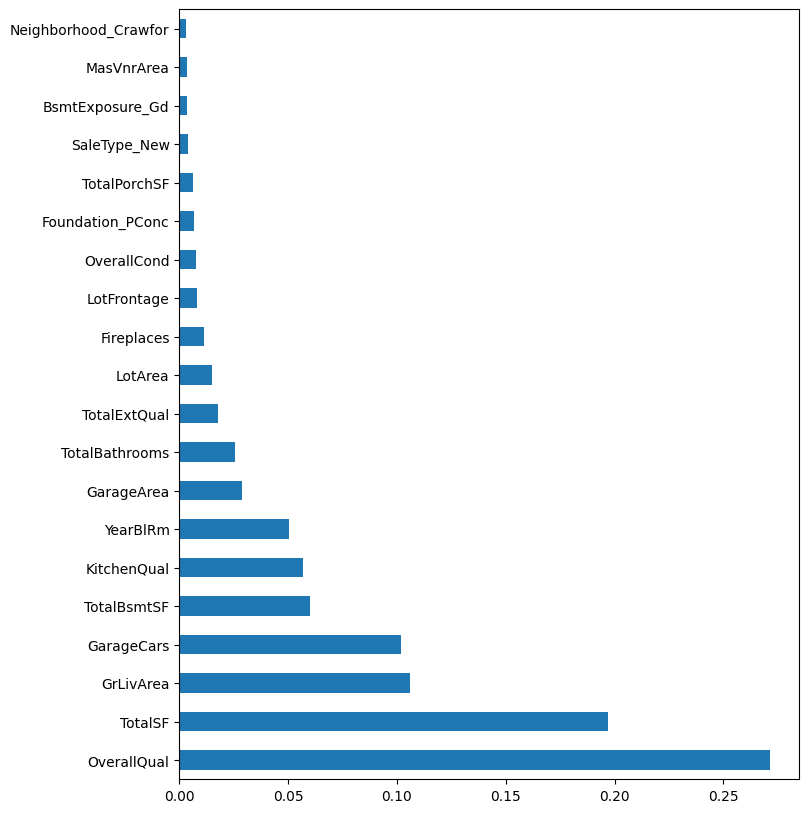

In [45]:
feat_importances = pd.Series(regressor.feature_importances_, index=cols_laso)
feat_importances.nlargest(20).plot(kind='barh')

In [46]:
y_pred = regressor.predict(X_test)

submission = pd.DataFrame(columns = ['Id', 'SalePrice'])
submission['Id'] = df_test.iloc[:, 0].values
submission['SalePrice'] = y_pred

In [47]:
submission.to_csv('submission.csv', index=False)

## Prediction with Neural Network

In [48]:
#import tensorflow as tf

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [50]:
ann = Sequential(
    [
        Dense(units=1024, activation='relu',kernel_initializer='he_uniform'),
        Dropout(0.2),
        Dense(units=512, activation='relu',kernel_initializer='he_uniform'),
        Dropout(0.2),
        Dense(units=256, activation='relu',kernel_initializer='he_uniform'),
        Dropout(0.2),
        Dense(units=128, activation='relu',  kernel_initializer='he_uniform'),
        Dense(units=64, activation='relu',kernel_initializer='he_uniform'),
        Dense(units=32, activation='relu',kernel_initializer='he_uniform'),
        Dense(units=1, activation='linear')
    ]
)

In [51]:
msle = MeanSquaredLogarithmicError()
ann.compile(optimizer = Adam(learning_rate=0.001), loss = msle, metrics = [msle])

In [52]:
earlystopping = EarlyStopping(monitor="val_loss",
                                        mode="min", patience=20,
                                        restore_best_weights=True)

In [53]:
history = ann.fit(X_, y, batch_size = 32, epochs = 200, validation_split=0.2, callbacks=[earlystopping])

Epoch 1/200
37/37 [==============================] - 3s 23ms/step - loss: 39.9239 - mean_squared_logarithmic_error: 39.5579 - val_loss: 12.0787 - val_mean_squared_logarithmic_error: 12.1605
Epoch 2/200
37/37 [==============================] - 0s 13ms/step - loss: 6.3431 - mean_squared_logarithmic_error: 6.2877 - val_loss: 2.7491 - val_mean_squared_logarithmic_error: 2.7837
Epoch 3/200
37/37 [==============================] - 1s 14ms/step - loss: 1.5122 - mean_squared_logarithmic_error: 1.5015 - val_loss: 0.6862 - val_mean_squared_logarithmic_error: 0.6982
Epoch 4/200
37/37 [==============================] - 0s 13ms/step - loss: 0.4172 - mean_squared_logarithmic_error: 0.4144 - val_loss: 0.2279 - val_mean_squared_logarithmic_error: 0.2286
Epoch 5/200
37/37 [==============================] - 0s 13ms/step - loss: 0.1871 - mean_squared_logarithmic_error: 0.1873 - val_loss: 0.1376 - val_mean_squared_logarithmic_error: 0.1338
Epoch 6/200
37/37 [==============================] - 0s 13ms/step 

In [54]:
y_pred = ann.predict(X_)

46/46 [==============================] - 0s 4ms/step


In [55]:
np.sqrt(mean_squared_log_error(y, y_pred))

0.08934299941677068

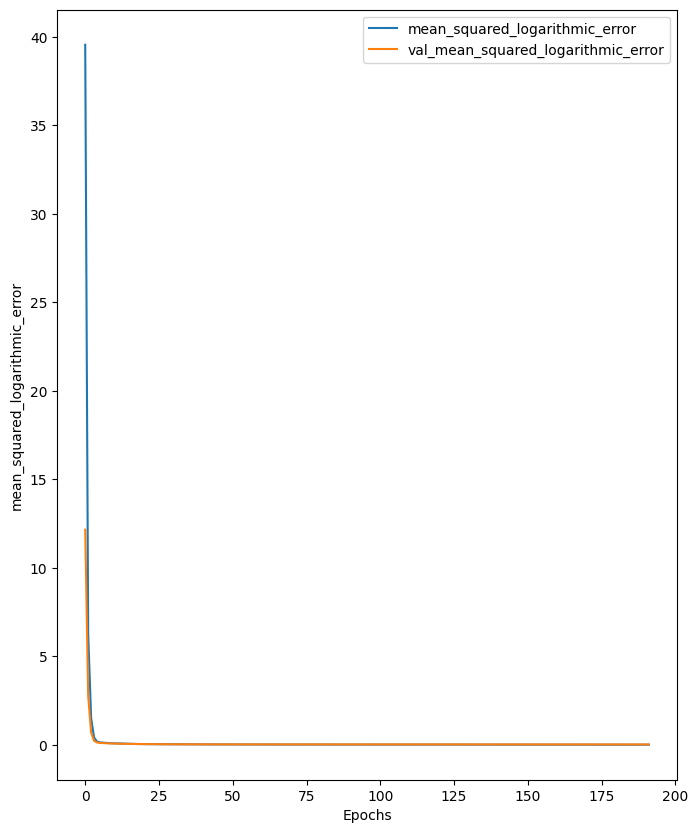

In [56]:
def plot_history(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()
# Plot the history
plot_history(history, 'mean_squared_logarithmic_error')

In [57]:
y_pred = ann.predict(X_test)

46/46 [==============================] - 0s 3ms/step
